In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:42519 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Merge

In [3]:
config = pd.Series({
    'path': os.path.abspath('dades'),
    'file_type':'csv',
    'years':[2019, 2020, 2021, 2022],
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [4]:
%%time

def read_data_all(cnfg:dict):

    data = dict()

    for year in cnfg.years:
        cnfg['year'] = year
        data[year] = load_checkpoint(cnfg)
    
    return dd.concat(list(data.values()), interleave_partitions=False)
    
bbdd_completa = read_data_all(config)   

checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
checkpoint reloaded.
CPU times: user 120 ms, sys: 35.9 ms, total: 156 ms
Wall time: 162 ms


## Fix error in data

In [5]:
%%time
# error fix
# 2019 gener, febrer and marc have the status reversed 

cond = (bbdd_completa.year == 2019) & (bbdd_completa.month.isin([1,2,3]))

bbdd_completa['status'] = bbdd_completa['status'].mask(cond, ((bbdd_completa['status'] + 1) %2))


CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 16.2 ms


## General view

In [9]:
filtered_bbdd.columns

NameError: name 'filtered_bbdd' is not defined

In [10]:

len(filtered_bbdd.divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

NameError: name 'filtered_bbdd' is not defined

In [11]:
filtered_bbdd.head(2)

NameError: name 'filtered_bbdd' is not defined

In [12]:
%%time

get_ddf_shape(filtered_bbdd)

NameError: name 'filtered_bbdd' is not defined

In [ ]:
%%time

nans = get_features_nans(filtered_bbdd)

zeros = get_features_zero(filtered_bbdd)

In [ ]:
nans

In [ ]:
zeros

In [ ]:
%%time 

uniques = get_columns_unique(filtered_bbdd)

In [ ]:
uniques

# Unique Station ID

In [6]:
%%time

print(stats.describe(bbdd_completa.station_id))
bbdd_completa.station_id.describe().compute()

DescribeResult(nobs=15989032, minmax=(1, 519), mean=248.5409774025094, variance=20765.938732625913, skewness=0.06035194275735312, kurtosis=-1.1130453623044292)
CPU times: user 4.75 s, sys: 1.35 s, total: 6.1 s
Wall time: 23.1 s


count    1.598903e+07
mean     2.485410e+02
std      1.441039e+02
min      1.000000e+00
25%      1.370000e+02
50%      2.720000e+02
75%      3.950000e+02
max      5.190000e+02
Name: station_id, dtype: float64

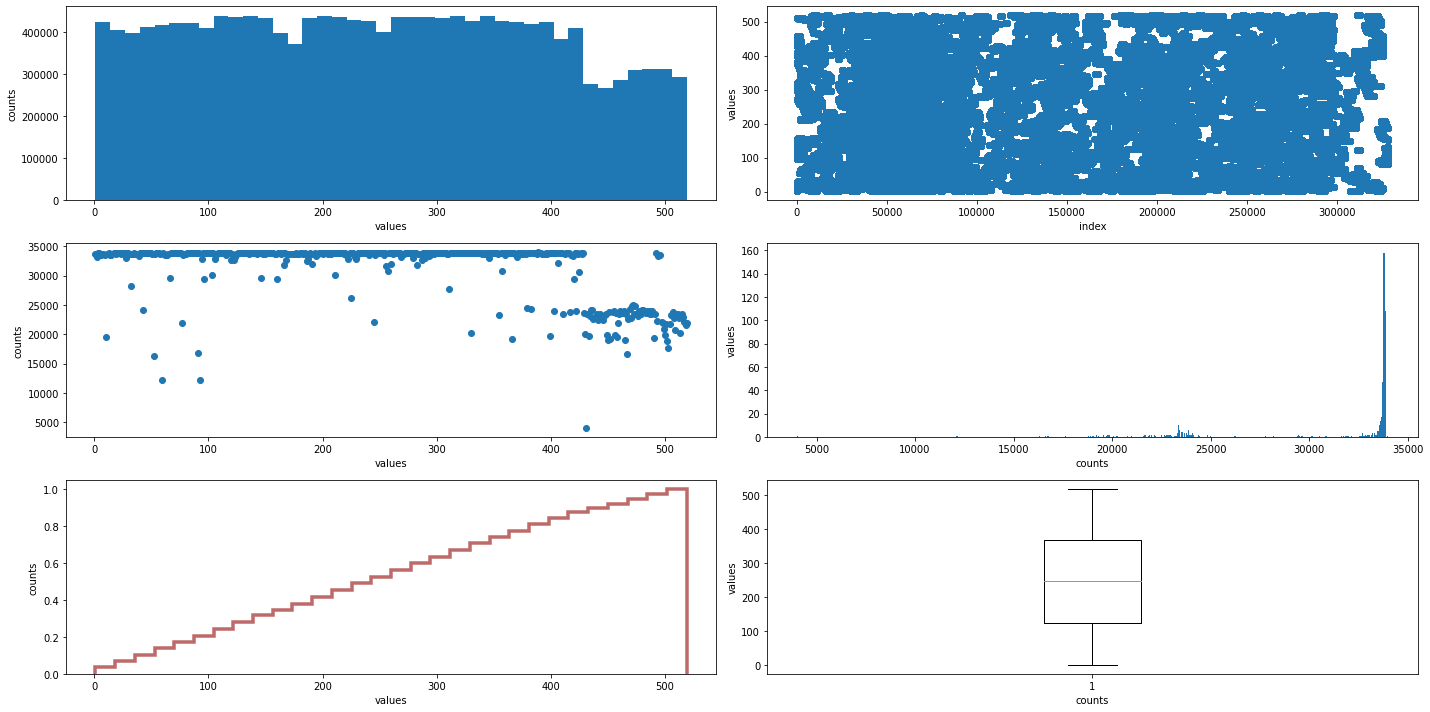

CPU times: user 28.4 s, sys: 1.83 s, total: 30.3 s
Wall time: 36.6 s


In [7]:
%%time

show_counts(bbdd_completa.station_id.compute())

In [8]:
uniques['station_id'].shape

NameError: name 'uniques' is not defined

In [ ]:
unique_ids_by_year = bbdd_completa.groupby('year')['station_id'].unique().compute()
print(unique_ids_by_year)

In [ ]:
%%time
# Calcula los station_id comunes en todos los años
common_ids = set(unique_ids_by_year[2019])
for year, ids in unique_ids_by_year.items():
    print(year, ids.shape)
    common_ids = common_ids.intersection(set(ids))
# common_ids
print(len(common_ids))

In [ ]:
filtered_bbdd = bbdd_completa[bbdd_completa['station_id'].isin(common_ids)]

In [ ]:
%%time

get_ddf_shape(filtered_bbdd)
#bbdd_completa.shape = (12531377, 23)

In [ ]:
uniques['timestamp'].shape

In [ ]:
xticks = np.asanyarray(
    (
        uniques['timestamp'].min(), 
        np.round(uniques['timestamp'].mean()-uniques['timestamp'].std()).astype(int),
        np.round(uniques['timestamp'].mean()).astype(int),
        np.round(uniques['timestamp'].mean()+uniques['timestamp'].std()).astype(int),
        uniques['timestamp'].max()
    )
)
xticks

In [ ]:
%%time

scatter_columns(
    filtered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

## IDs no comunes (testing)

In [ ]:
nonfiltered_bbdd = bbdd_completa[~bbdd_completa['station_id'].isin(common_ids)]

In [ ]:
%%time

get_ddf_shape(nonfiltered_bbdd)
#bbdd_completa.shape = (12531377, 23)

In [ ]:
%%time

scatter_columns(
    nonfiltered_bbdd, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8)
)

# Data exploration__________________________________

## · Descriptiva
Media, mediana, desviación estándar, mínimo y máximo para columnas numéricas Idea general de la distribución y el rango de los valores en esas columnas.

<div>
    <table>
        <tr>
            <th><p>Camp<p><th>
            <th><p>Descripció<p><th>
        <tr>
        <tr>
            <td><p>last_updated<p><td>
            <td><p>Timestamp de l'arxiu<p><td>
        <tr>
        <tr>
            <td><p>ttl<p><td>
            <td><p>TimeToLive de la resposta<p><td>
        <tr>
        <tr>
            <td><p>data<p><td>
            <td><p>Contenidor d'arrays d'informació d'estacions<p><td>
        <tr>
        <tr>
            <td><p>stations<p><td>
            <td><p>Array de dades de cada estació<p><td>
        <tr>
        <tr>
            <td><p>station_id<p><td>
            <td><p>Identificador de l'estació<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available<p><td>
            <td><p>Nombre de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_bikes_available_types<p><td>
            <td><p>Array de tipus de bicicletes disponibles<p><td>
        <tr>
        <tr>
            <td><p>mechanical<p><td>
            <td><p>Nombre de bicicletes mecàniques disponibles<p><td>
        <tr>
        <tr>
            <td><p>ebike<p><td>
            <td><p>Nombre de bicicletes elèctriques disponibles<p><td>
        <tr>
        <tr>
            <td><p>num_docks_available<p><td>
            <td><p>Nombre de ancoratges disponibles<p><td>
        <tr>
        <tr>
            <td><p>is_installed<p><td>
            <td><p>L'estació està correctament instalada (0-NO,1-SI)<p><td>
        <tr>
        <tr>
            <td><p>is_renting<p><td>
            <td><p>L'estació està proporcionant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>is_returning<p><td>
            <td><p>L'estació està ancorant bicicletes correctament<p><td>
        <tr>
        <tr>
            <td><p>last_reported<p><td>
            <td><p>Timestamp de la informació de l'estació<p><td>
        <tr>
        <tr>
            <td><p>is_charging_station<p><td>
            <td><p>L'estació té capacitat de càrrega de bicicletes elèctriques<p><td>
        <tr>
        <tr>
            <td><p>status<p><td>
            <td><p>
                Estat de l'estació (IN_SERVICE=En servei, CLOSED=Tancada)
                 ['IN_SERVICE', 'OPEN', 'OPN', 'CLS', 'CLOSED', 'NOT_IN_SERVICE', 'MAINTENANCE', 'PLANNED']                     [0, 0, 0, 1, 1, 1,  2, 3]
                <p><td>
        <tr>
    <table>
<div>

# Time columns 

## 'timestamp'

DescribeResult(nobs=13695947, minmax=(1546300800, 1672527600), mean=1610620803.8328128, variance=1353616641135981.8, skewness=-0.06851532428616208, kurtosis=-1.2127003883773737)


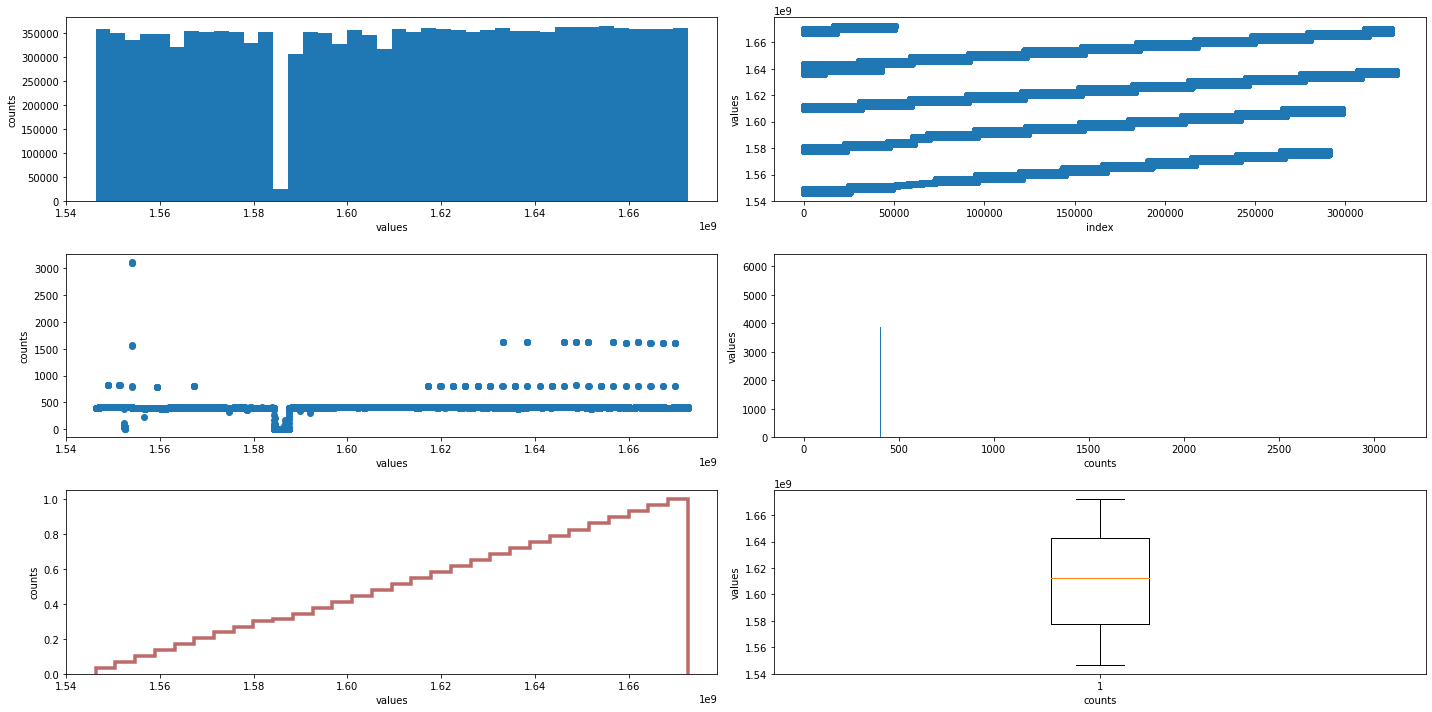

CPU times: user 1min 22s, sys: 7.41 s, total: 1min 29s
Wall time: 1min 40s


In [28]:
%%time
print(stats.describe(filtered_bbdd.timestamp))
filtered_bbdd.timestamp.describe()

show_counts(filtered_bbdd.timestamp.compute())

## 'year' 

DescribeResult(nobs=13695947, minmax=(2019, 2022), mean=2020.531785571308, variance=1.2810948163779952, skewness=-0.05973991118702524, kurtosis=-1.3877630637407383)


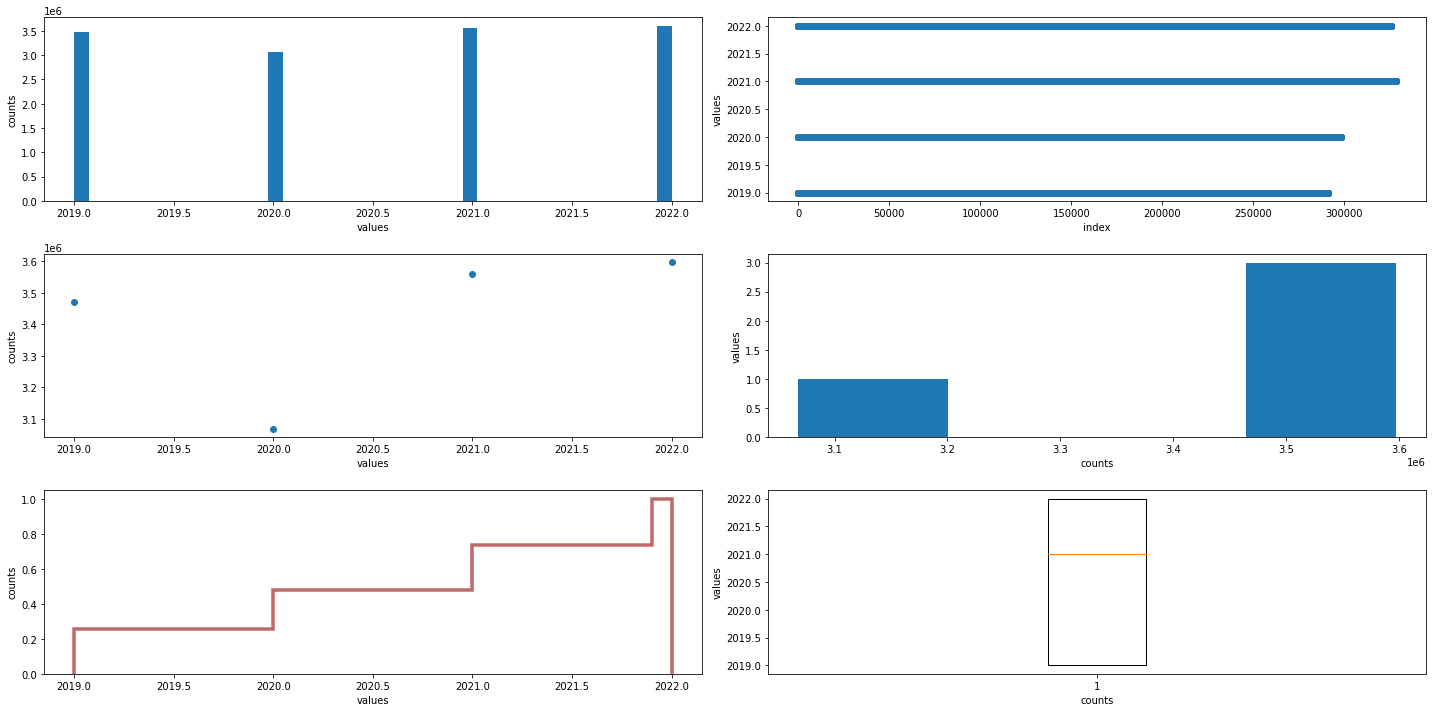

CPU times: user 24.4 s, sys: 1.24 s, total: 25.7 s
Wall time: 38.1 s


In [29]:
%%time
print(stats.describe(filtered_bbdd.year))
filtered_bbdd.year.describe()
show_counts(filtered_bbdd.year.compute())

## 'month'

DescribeResult(nobs=13695947, minmax=(1, 12), mean=6.596964634866066, variance=11.970971522025115, skewness=-0.055679864777547855, kurtosis=-1.2017629693595469)


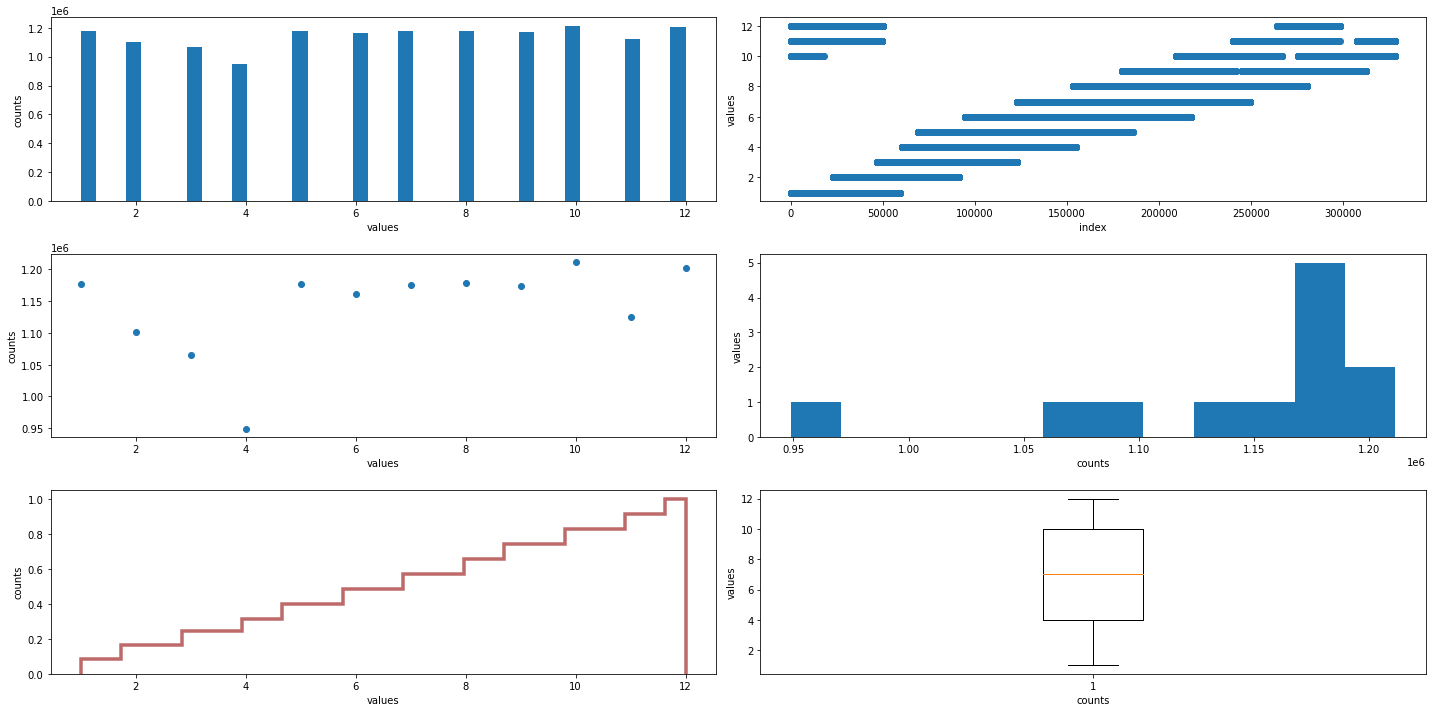

CPU times: user 27 s, sys: 1.24 s, total: 28.2 s
Wall time: 41.2 s


In [30]:
%%time
print(stats.describe(filtered_bbdd.month))
filtered_bbdd.month.describe()
show_counts(filtered_bbdd.month.compute())

## 'dayofweek' 

DescribeResult(nobs=13695947, minmax=(0, 6), mean=2.992969306905174, variance=3.9924149087986, skewness=0.004769799862812546, kurtosis=-1.2475598280214848)


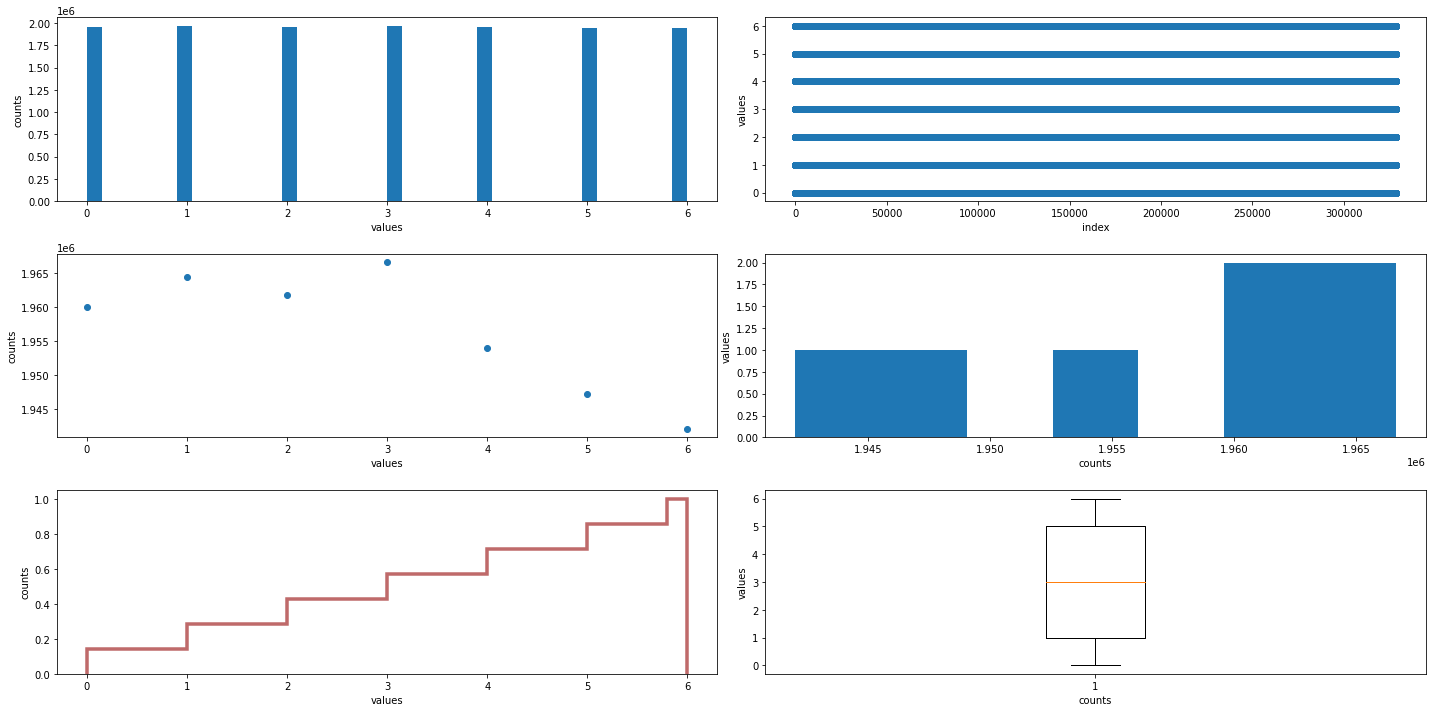

CPU times: user 24.4 s, sys: 1.21 s, total: 25.6 s
Wall time: 37.9 s


In [31]:
%%time
print(stats.describe(filtered_bbdd.dayofweek))
filtered_bbdd.dayofweek.describe()
show_counts(filtered_bbdd.dayofweek.compute())

## 'day'

DescribeResult(nobs=13695947, minmax=(1, 31), mean=15.701012277573795, variance=78.22064786146805, skewness=0.0072689640511584335, kurtosis=-1.188724646064481)


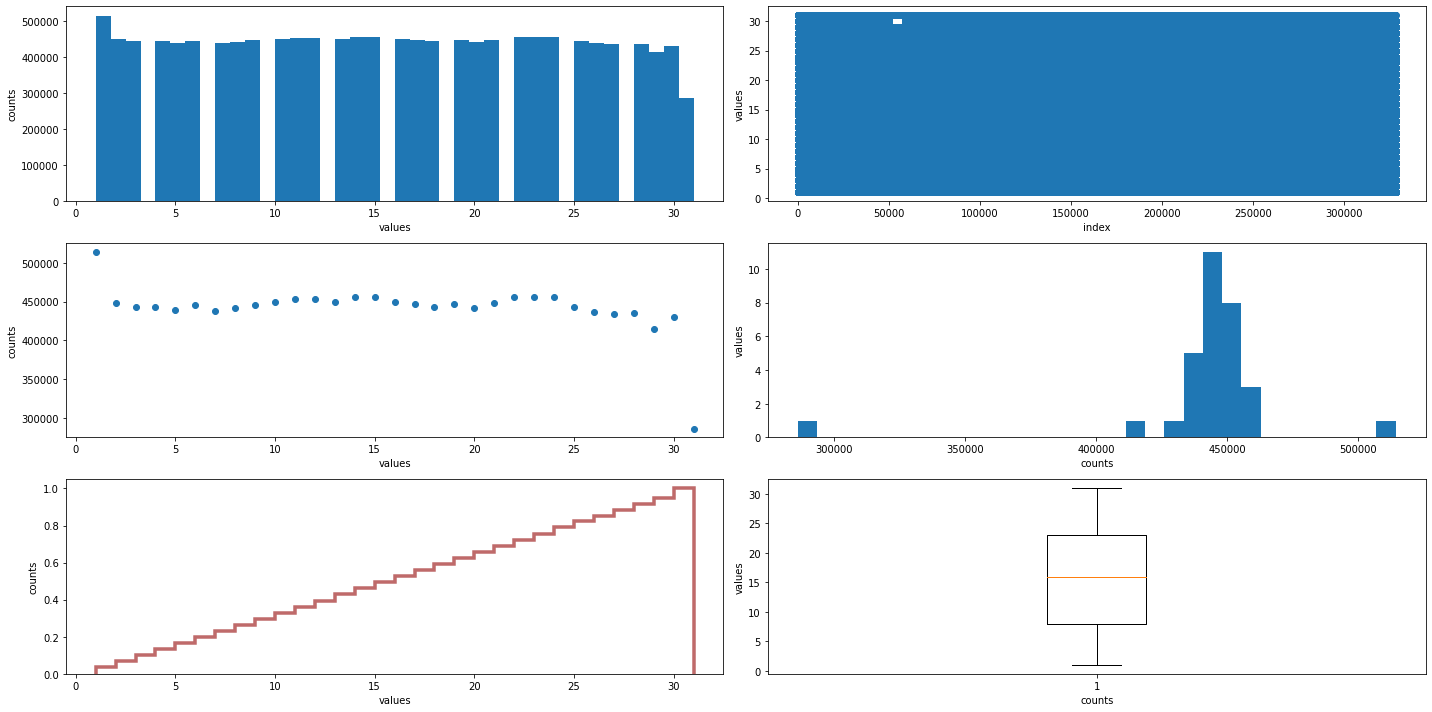

CPU times: user 24.8 s, sys: 1.29 s, total: 26.1 s
Wall time: 39.5 s


In [32]:
%%time
print(stats.describe(filtered_bbdd.day))
filtered_bbdd.day.describe()
show_counts(filtered_bbdd.day.compute())

## 'dayofyear' 

DescribeResult(nobs=13695947, minmax=(1, 366), mean=185.34085711634253, variance=11187.660394319013, skewness=-0.04836758395761228, kurtosis=-1.193248607401424)


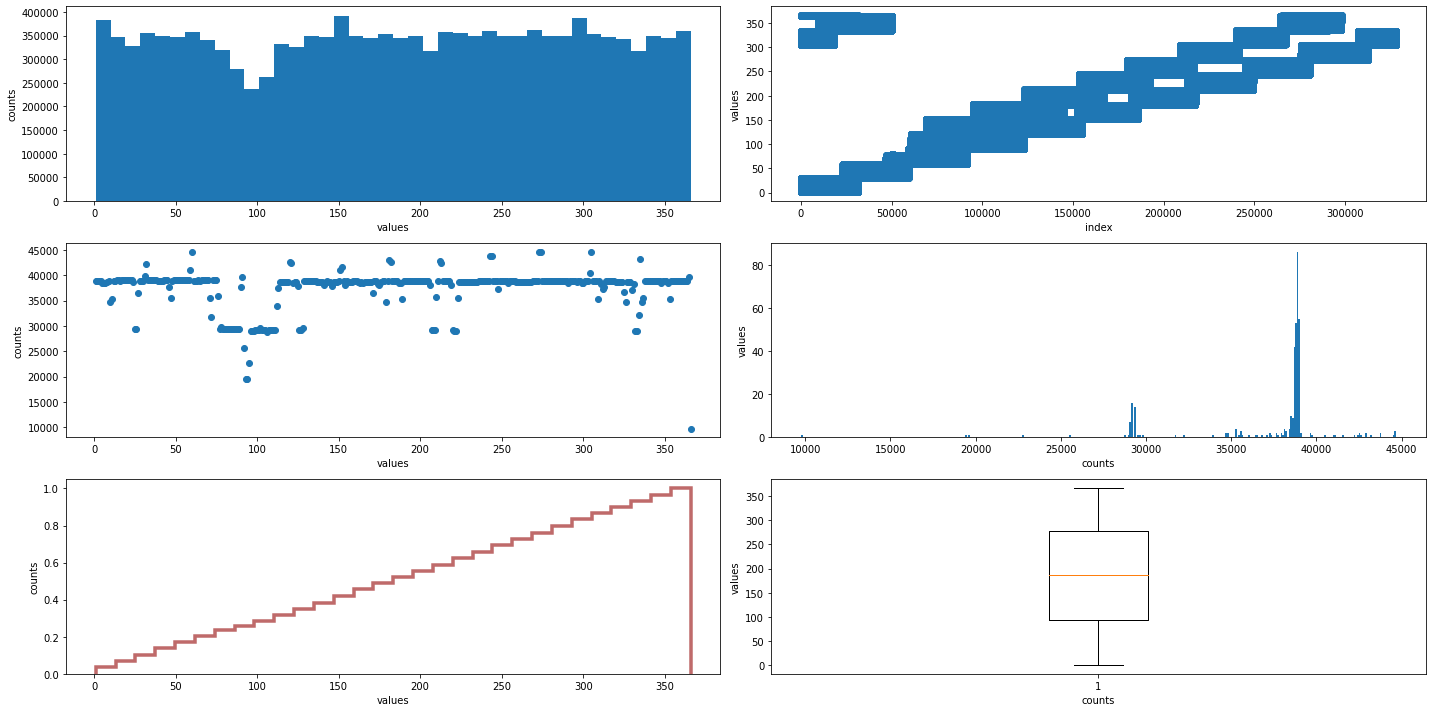

CPU times: user 25.2 s, sys: 1.46 s, total: 26.7 s
Wall time: 39.4 s


In [33]:
%%time
print(stats.describe(filtered_bbdd.dayofyear))
filtered_bbdd.dayofyear.describe()
show_counts(filtered_bbdd.dayofyear.compute())

## 'hour'

DescribeResult(nobs=13695947, minmax=(0, 23), mean=11.503686674605268, variance=48.340680709502074, skewness=-0.001689360207134869, kurtosis=-1.2092637188130513)


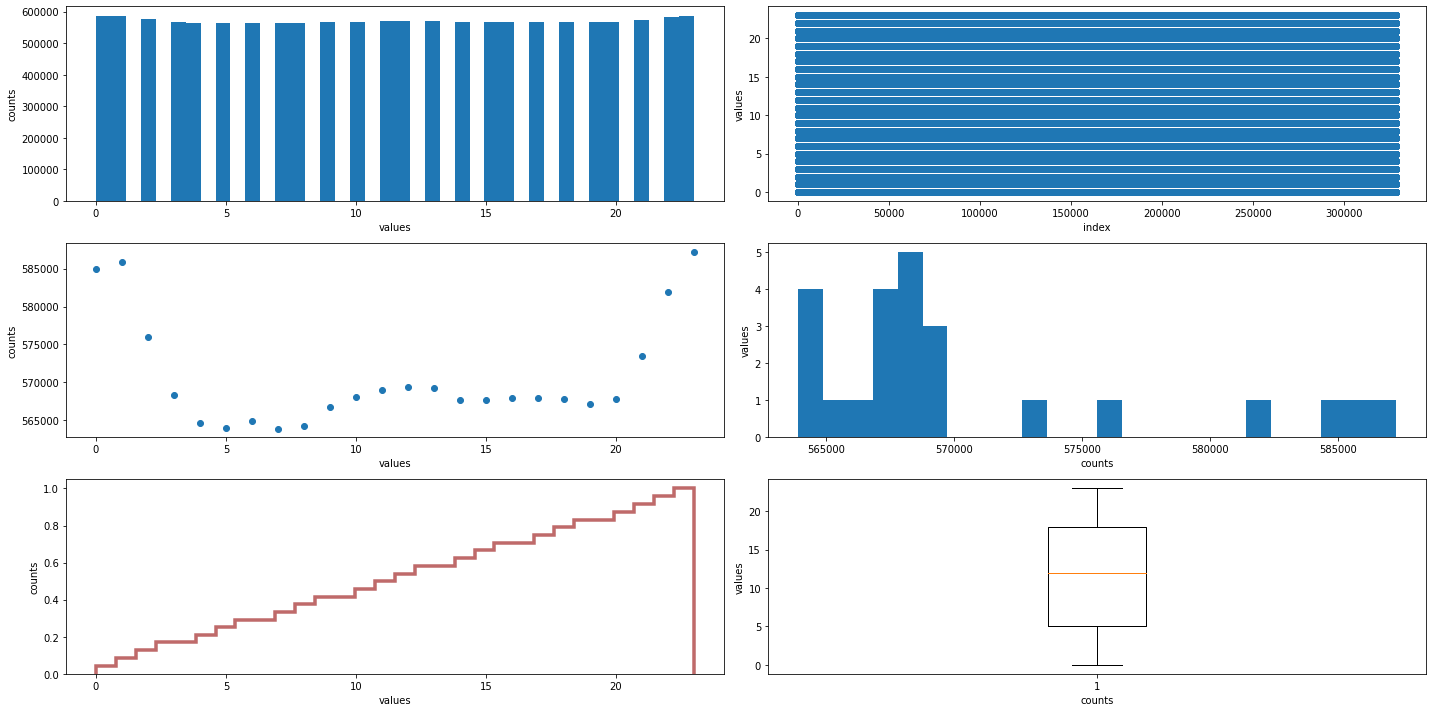

CPU times: user 24.8 s, sys: 1.1 s, total: 25.9 s
Wall time: 38.5 s


In [34]:
%%time
print(stats.describe(filtered_bbdd.hour))
filtered_bbdd.hour.describe()
show_counts(filtered_bbdd.hour.compute())

# Status Columns 

## 'status'

DescribeResult(nobs=13695947, minmax=(0, 3), mean=0.03460994701571202, variance=0.03599563924648927, skewness=5.69942409550984, kurtosis=34.89012764781221)


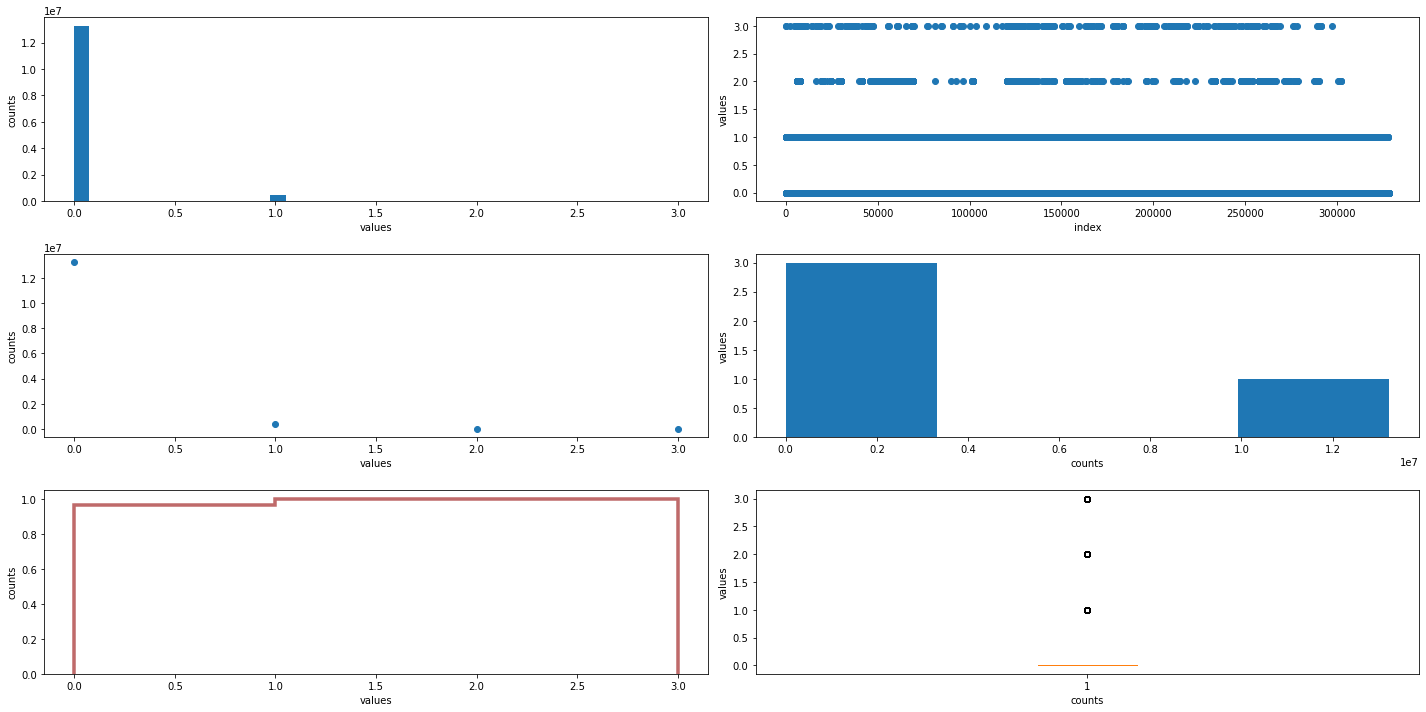

CPU times: user 24.9 s, sys: 1.11 s, total: 26 s
Wall time: 38.5 s


In [35]:
%%time
print(stats.describe(filtered_bbdd.status))
filtered_bbdd.status.describe()
show_counts(filtered_bbdd.status.compute())

## 'is_installed'

DescribeResult(nobs=13695947, minmax=(0, 1), mean=0.9999391060727674, variance=6.08902236081191e-05, skewness=-128.1366413710492, kurtosis=16416.998861855525)


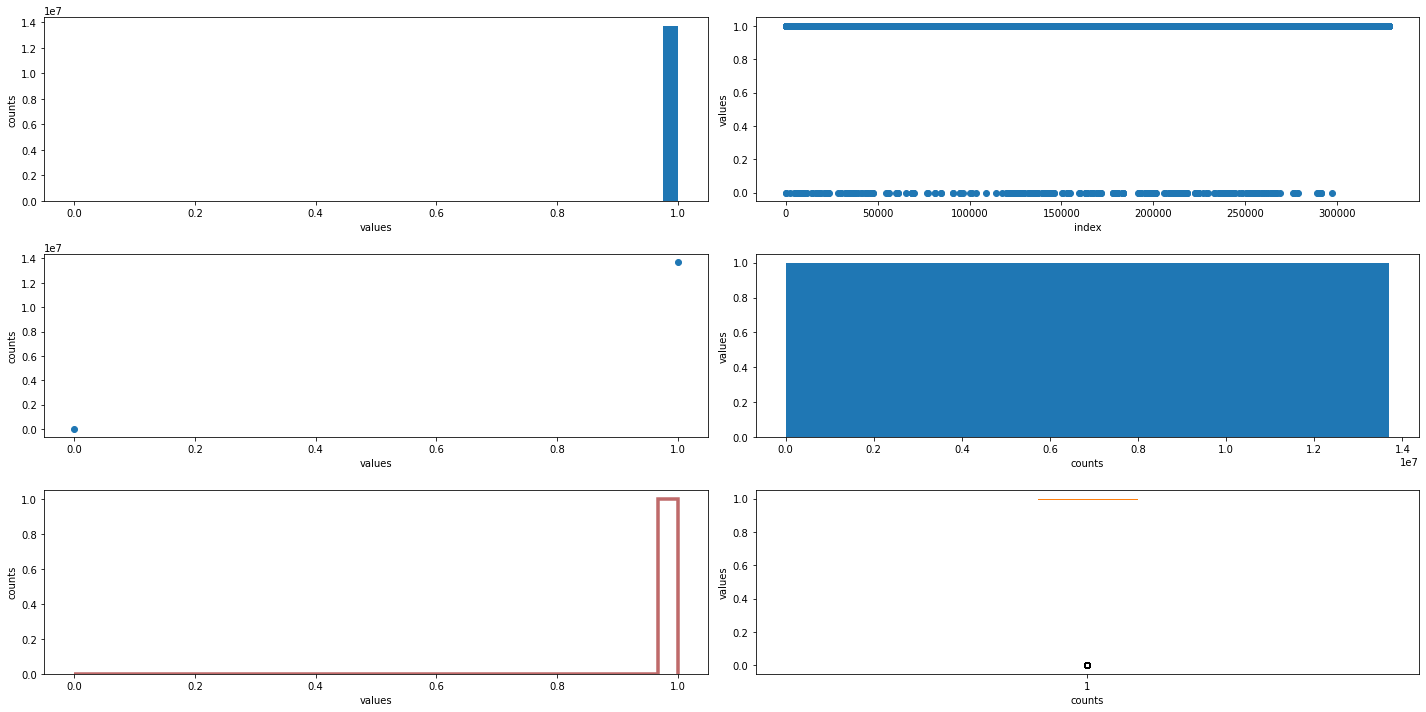

CPU times: user 24.1 s, sys: 1.11 s, total: 25.2 s
Wall time: 38 s


In [36]:
%%time
print(stats.describe(filtered_bbdd.is_installed))
filtered_bbdd.is_installed.describe()
show_counts(filtered_bbdd.is_installed.compute())

## 'is_renting'

DescribeResult(nobs=13695947, minmax=(0, 1), mean=0.9980996567816741, variance=0.001896732052466933, skewness=-22.87406033650052, kurtosis=521.2226362778562)


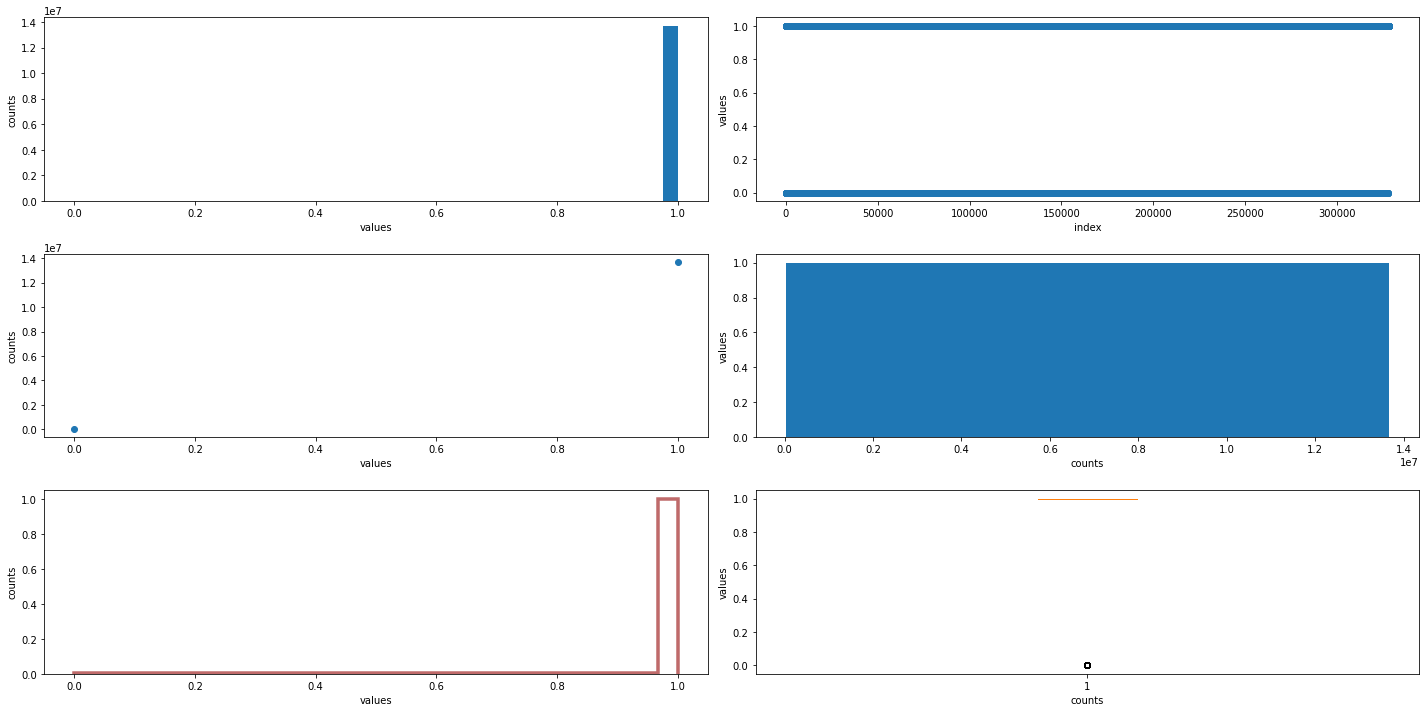

CPU times: user 24.7 s, sys: 958 ms, total: 25.7 s
Wall time: 38.3 s


In [37]:
%%time
print(stats.describe(filtered_bbdd.is_renting))
filtered_bbdd.is_renting.describe()
show_counts(filtered_bbdd.is_renting.compute())

## 'is_returning'

DescribeResult(nobs=13695947, minmax=(0, 1), mean=0.9981293736022782, variance=0.0018671272909290503, skewness=-23.056065643752813, kurtosis=529.5821629690406)


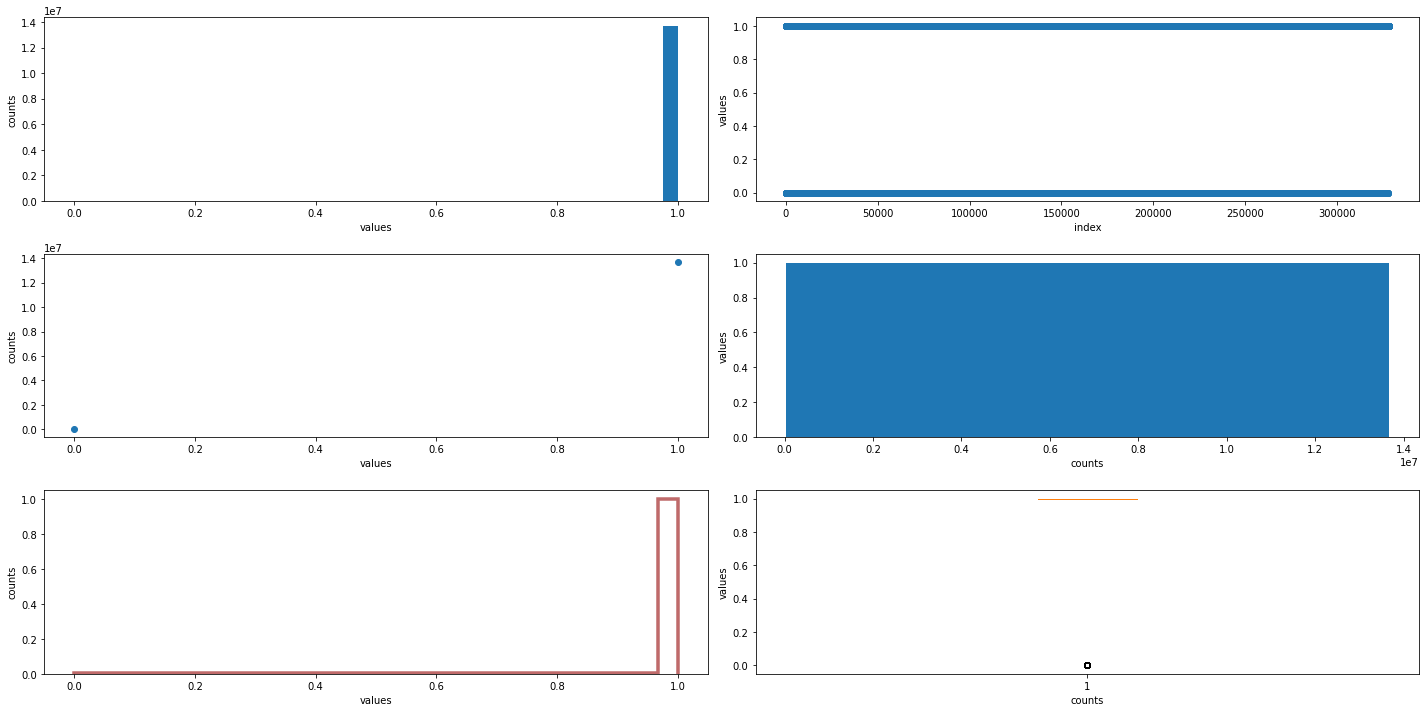

CPU times: user 24 s, sys: 1.24 s, total: 25.2 s
Wall time: 37.2 s


In [38]:
%%time
print(stats.describe(filtered_bbdd.is_returning))
filtered_bbdd.is_returning.describe()
show_counts(filtered_bbdd.is_returning.compute())

## 'is_charging_station'

DescribeResult(nobs=13695947, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)


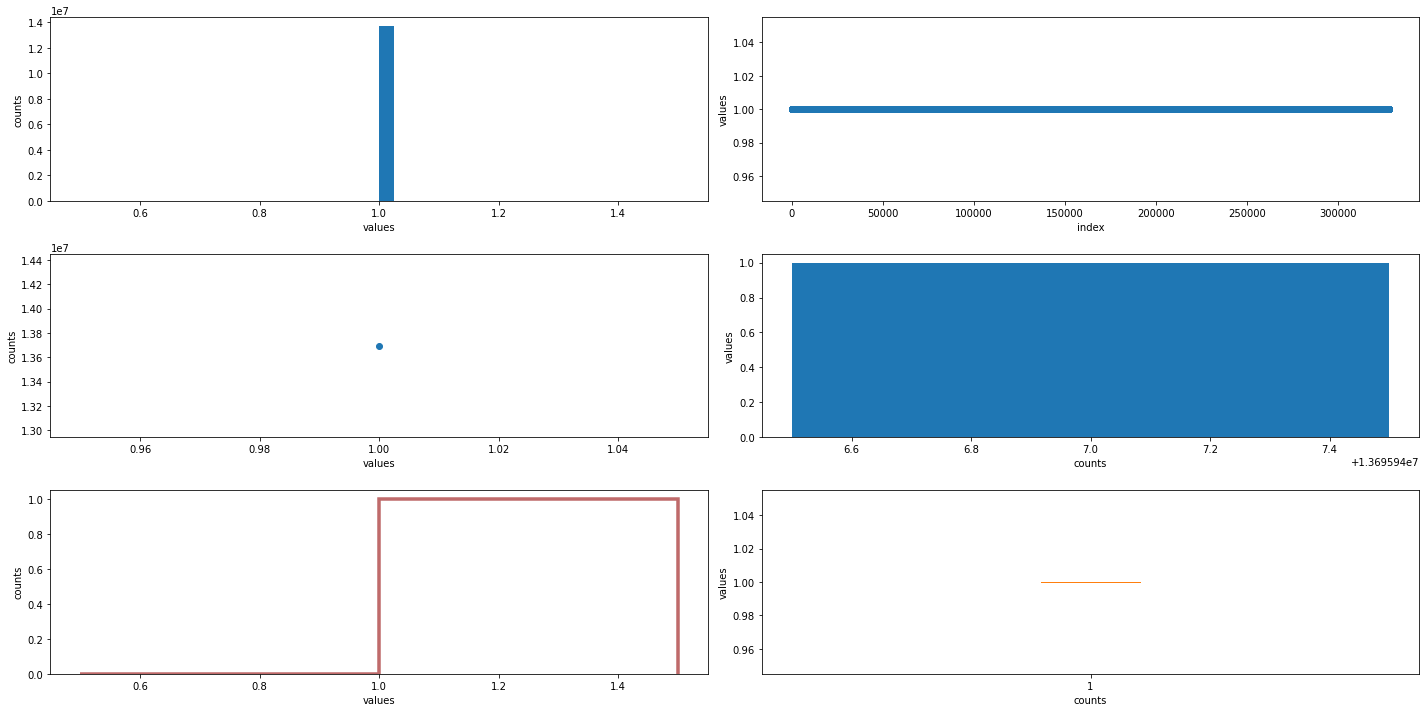

CPU times: user 24 s, sys: 1.15 s, total: 25.2 s
Wall time: 37.1 s


In [39]:
%%time
print(stats.describe(filtered_bbdd.is_charging_station))
filtered_bbdd.is_charging_station.describe()
show_counts(filtered_bbdd.is_charging_station.compute())

## Study 

In [40]:
def filter_data(data, row_data, row_index):
    cat_cols = row_data.select_dtypes(include=['object']).columns
    num_cols = row_data.select_dtypes(exclude=['object']).columns
    
    filtered = data.copy()
    
    row = row_data.loc[row_index]
    for num_col in num_cols:
        filtered = filtered[filtered[num_col] == row[num_col]]
    
    for cat_col in cat_cols:
        filtered = filtered[filtered[cat_col].isin(row[cat_col])]
    
    return filtered

In [52]:
filtered_bbdd.groupby(
    [         
        'status',
        'is_installed',
        'is_renting', 
        'is_returning'
    ]
).station_id.sum().compute().reset_index().sort_values(['status','is_installed','is_renting','is_returning']).reset_index(drop=True)


,status,is_installed,is_renting,is_returning,station_id
0,0,1,0,0,161415
1,0,1,0,1,57835
2,0,1,1,1,2863264451
3,1,1,0,0,1934343
4,1,1,0,1,27493
5,1,1,1,1,94538323
6,2,0,0,0,11356
7,2,1,0,0,3438953
8,3,0,0,0,147565
9,3,1,1,1,494


In [50]:
status_of_station = filtered_bbdd.groupby(
    [         
        'status',
        'is_installed',
        'is_renting', 
        'is_returning'
    ]
)['station_id'].unique().compute()

status_of_station = pd.DataFrame(status_of_station).reset_index()
status_of_station = status_of_station.sort_values(['status','is_installed','is_renting','is_returning']).reset_index(drop=True)
status_of_station

,status,is_installed,is_renting,is_returning,station_id
0,0,1,0,0,"[396, 222, 89, 184, 351, 187, 424, 307, 23, 12..."
1,0,1,0,1,"[94, 352, 223, 42, 351, 404, 78, 220, 345, 61,..."
2,0,1,1,1,"[1, 320, 319, 318, 317, 316, 315, 314, 313, 31..."
3,1,1,0,0,"[332, 346, 344, 42, 339, 298, 290, 71, 352, 13..."
4,1,1,0,1,"[348, 347, 405, 297, 296, 318, 288, 284, 334, ..."
5,1,1,1,1,"[1, 318, 311, 310, 321, 307, 305, 304, 302, 29..."
6,2,0,0,0,"[194, 106, 311, 387, 205, 170, 225, 375, 406, ..."
7,2,1,0,0,"[54, 373, 208, 89, 349, 272, 377, 133, 346, 36..."
8,3,0,0,0,"[406, 171, 74, 123, 51, 256, 425, 310, 419, 38..."
9,3,1,1,1,[494]


value counts stats {'max': 8, 'mean': 2.288184438040346, 'median': 2.0, 'std': 1.4051737145977476, 'min': 1}


  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 43.5 s, sys: 4.02 s, total: 47.5 s
Wall time: 3min 26s


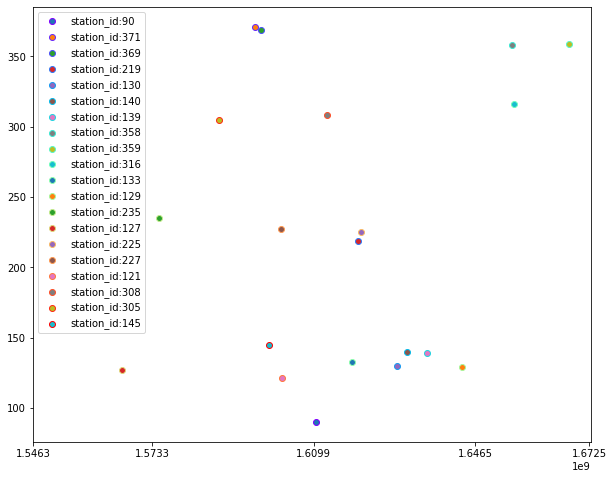

In [51]:
%%time

# case of station with opened status and is installed but it is not renting and not returning
filtered = filter_data(filtered_bbdd, status_of_station, 0)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=20
)

value counts stats {'max': 14, 'mean': 1.1612903225806452, 'median': 1.0, 'std': 1.0521337269750384, 'min': 1}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 12.1 s, sys: 1.56 s, total: 13.7 s
Wall time: 59.4 s


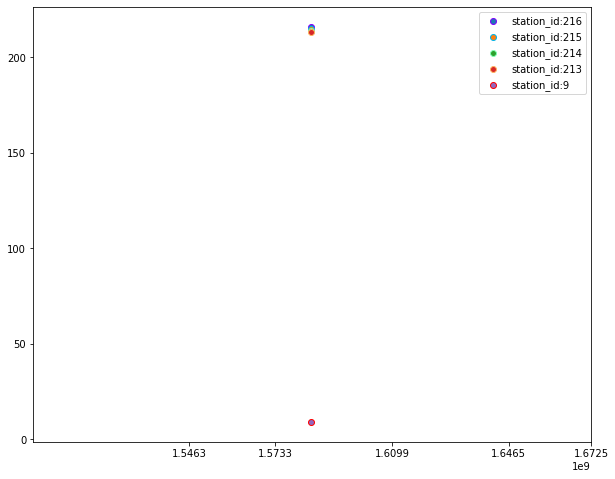

In [53]:
%%time

# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 1)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

value counts stats {'max': 33598, 'mean': 32445.406862745098, 'median': 32569.0, 'std': 999.295555885122, 'min': 25808}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 13.6 s, sys: 1.19 s, total: 14.8 s
Wall time: 59.9 s


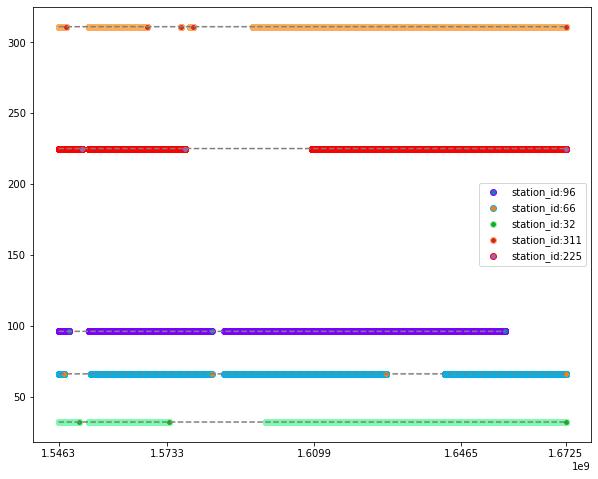

In [54]:
%%time
# case of station with opened status and is installed and is renting and returning
filtered = filter_data(filtered_bbdd, status_of_station, 2)

scatter_columns(
    filtered, 
    'timestamp', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=xticks,
    figsize=(10,8),
    count=5
)

# Goal Columns 

## 'num_docks_available' 

In [ ]:
%%time
print(stats.describe(filtered_bbdd.num_docks_available))
filtered_bbdd.num_docks_available.describe()
show_counts(filtered_bbdd.num_docks_available.compute())

## 'num_bikes_available' 

In [ ]:
%%time
print(stats.describe(filtered_bbdd.num_bikes_available))
filtered_bbdd.num_bikes_available.describe()
show_counts(filtered_bbdd.num_bikes_available.compute())

## 'num_bikes_available_types.mechanical'

In [ ]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.mechanical']))
filtered_bbdd['num_bikes_available_types.mechanical'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.mechanical'].compute())

## 'num_bikes_available_types.ebike'

In [ ]:
%%time
print(stats.describe(filtered_bbdd['num_bikes_available_types.ebike']))
filtered_bbdd['num_bikes_available_types.ebike'].describe()
show_counts(filtered_bbdd['num_bikes_available_types.ebike'].compute())

## 'capacity' 

In [ ]:
%%time
print(stats.describe(filtered_bbdd.capacity))
filtered_bbdd.capacity.describe()
show_counts(filtered_bbdd.capacity.compute())

## 'ctx0'

In [ ]:
%%time
print(stats.describe(filtered_bbdd.ctx0))
filtered_bbdd.ctx0.describe()
show_counts(filtered_bbdd.ctx0.compute())

## · Visualización de la disponibilidad de bicicletas
Gráficos para visualizar la disponibilidad de bicicletas a lo largo del tiempo. Ejemplo: cantidad de bicicletas disponibles en función del tiempo para identificar patrones diarios, semanales o estacionales.

## · Análisis temporal
Datos por año, mes, día de la semana o hora del día para conocer estadísticas agregadas, como el promedio de bicicletas disponibles o el porcentaje de anclajes disponibles. Tendencias temporales y patrones de uso.

## · Relación entre variables
Explorar si hay una correlación entre el número de anclajes disponibles (num_docks_available) y el número de bicicletas disponibles (num_bikes_available). Investigar si la disponibilidad de bicicletas difiere entre los diferentes tipos de bicicletas (mecánicas y eléctricas).

## · Análisis de capacidad y porcentaje de anclajes disponibles
Capacidad (capacity) y los porcentajes de anclajes disponibles (ctx0, ctx1, ctx2, ctx3, ctx4). Promedio distribución de la capacidad y los porcentajes de anclajes disponibles. Objetivo: entender la utilización de las estaciones de bicicletas a lo largo del tiempo.

## Data Cleaning

In [ ]:
1- hay que mirar los timestamps y limpiar repetidos.
2- quitar la columna 'is_charging_station'

# Predicción__________________________________
a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

In [ ]:
pipeline = escoger columnas para el training + modificar algunas (normalizar, logaritm, estadarizar, onehotencoded (1,0,1,0), ordinalencoding (1,2,3,4,5))

split = .2 o usar el nonfiltered_ddbb 

y_train = filtered_bbdd.ctx0
filtered_bbdd = filtered_bbdd.drop('ctx0')
X_train = pipeline(filtered_bbdd)


y_val = nonfiltered_bbdd.ctx0
nonfiltered_bbdd = filtered_bbdd.drop('ctx0')
X_val = pipeline(nonfiltered_bbdd)



In [ ]:

model = 

fit(X_rain, y_train)

para mirar over fitting 
rmse1 entre y_train,y_hat_training


id, year, mes, dia, hora, ctx1, ctx2, ctx3, ctx4 
y_hat_validation = predict(X_var)


validar con y_val,y_hat_validation
rmse2 entre y_val,y_hat_validation


miramos la differencia entre los dos para saber si hay overfiiting
si rmse1 es mucho mas pequeña que la rmse2 = overfitting
si es al reves = underfitting

y_hat = predict(X_test) # data de kaggle

guardar el csv con los resultados del test (index, y_hat)

In [ ]:
logear los resultado 

# Datos adicionales
Tiempo, festivos Barcelona